In [1]:
import os
import re
import json
import math
import time
import demoji
import curlify
import requests
import pandas as pd

import pickle
from scipy.special import softmax

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tqdm.notebook import tqdm

all_stopwords = stopwords.words('english')
pd.set_option('display.max_colwidth', None)

bearer_token = "AAAAAAAAAAAAAAAAAAAAADSXjAEAAAAAQ32sCpTWcilVX%2BQj0BjOArOSYCE%3DUax6ZCizLRwwQcWQirExGQEDEB903dxBZKM4LAuGTMTvMa4jVP"

from datetime import date

today = date.today()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/crarojasca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SCRAP_CTTS = True
SCRAP_DENIALS = True

## Functions

In [3]:
s = requests.Session()
def getTweets(query, max_results=None, next_token=None):
    # Twitter Endpoint
    url = "https://api.twitter.com/2/tweets/search/recent"
    
    # Auth Bearer no research access or premium for the moment
    headers = {
        "Authorization": "Bearer {}".format(bearer_token)
    }
    
    # Query parameters
    params = {
        'query': query,
    #     'start_time': start_date,
    #     'end_time': end_date,
        'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
        'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
        'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
        'next_token': {}
    }
    if max_results: params['max_results'] = max_results
    if next_token: params['next_token'] = next_token

    try:
        time.sleep(6)
        req = requests.Request(
            "GET",
            url,
            params=params,
            headers=headers
        ).prepare()

        response = s.send(req)
        results = json.loads(response.text)
        return results
    except:
        print(json.loads(response.text))

def getUser(username):
    # User Endpoint 
    url = "https://api.twitter.com/2/users/by/username/" + username
    # Auth Bearer no research access or premium for the moment
    headers = {
        "Authorization": "Bearer {}".format(bearer_token)
    }

    params = {
        'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
        'next_token': {}
    }
    
    time.sleep(1)
    try:
        req = requests.Request(
            "GET",
            url,
            params=params,
            headers=headers
        ).prepare()

        response = s.send(req)
        results = json.loads(response.text)["data"]

        return json.loads(response.text)["data"]
    except:
        print(json.loads(response.text)["errors"][0]["detail"])


def count_tweets(query):
    # User Endpoint 
    url = "https://api.twitter.com/2/tweets/counts/recent"
    # Auth Bearer no research access or premium for the moment
    headers = {
        "Authorization": "Bearer {}".format(bearer_token)
    }

    params = {
        "query": query,
        "granularity": "day"
    }

    time.sleep(1)
    req = requests.Request(
        "GET",
        url,
        params=params,
        headers=headers
    ).prepare()

    response = s.send(req)
    results = json.loads(response.text)
    return results["meta"]["total_tweet_count"]
    
    
def extract_data(query, max_result=100):
    data = pd.DataFrame()

    # Scrap all the data up to the last page
    next_token = None

    n_tweets = count_tweets(query)
    if n_tweets==0:
        return data
    
    #
    pbar = tqdm(total=math.ceil(n_tweets/max_result))
    while True:
        pbar.update(1)
        try:
            results = getTweets(query=query, max_results=max_result, next_token=next_token)
            data = pd.concat([data, pd.DataFrame(results["data"])], ignore_index=True)
            if not "next_token" in results["meta"]:
                break
            next_token = results["meta"]["next_token"] 
        except:
            print(results)
            break
    pbar.close()
    
    # Reordering de columns
    columns = list(data.columns)
    columns.remove("text")
    columns.remove("public_metrics")
    data = data[["text", "public_metrics"] + columns]
    return data

def preprocess_text(text):
    # Lower
    preprocessed_text = text.lower()
    # Remove Handle
    preprocessed_text = re.sub("@\w+", "", preprocessed_text)
    # Remove Hashtag
    preprocessed_text = re.sub("#\w+", "", preprocessed_text)
    # Remove Links
    preprocessed_text = re.sub(r'http[s]?:\S+', '', preprocessed_text, flags=re.MULTILINE)
    # Remove emotes 
    preprocessed_text = demoji.replace(preprocessed_text, "")
    # Remove new line
    preprocessed_text = re.sub("\\n", "", preprocessed_text)
    # Remove extra spaces 
    preprocessed_text = preprocessed_text.strip()
    
    return preprocessed_text

def get_data(query):
    results = extract_data(query)
    results["preprocessed_text"] = results["text"].apply(preprocess_text)
    results = results.sort_values(by="created_at", ascending=False)
    results = results.drop_duplicates(subset=['text'], keep='last')
    results = results[(results.preprocessed_text!="")].copy(deep=True)
    return results

## ClimateScam
### Original Page

In [4]:
results = get_data("from:ClimateScam")
print(results.shape)
results[["preprocessed_text", "text", "public_metrics"]]

  0%|          | 0/1 [00:00<?, ?it/s]

(7, 12)


,preprocessed_text,text,public_metrics
0,"greenies believe crisis sells. per npr: ""climate change is making aircraft turbulence worse."" no real world turbulence data demonstrating a problem in a warming world was included. the usual ""climate model studies"" for 60 years into the future were referenced. send $","Greenies believe crisis sells. Per NPR: ""climate change is making aircraft turbulence worse."" No real world turbulence data demonstrating a problem in a warming world was included. The usual ""climate model studies"" for 60 years into the future were referenced. Send $ #climatescam","{'retweet_count': 9, 'reply_count': 4, 'like_count': 24, 'quote_count': 1, 'impression_count': 944}"
1,"mitsubishi &amp; south pole, both ""carbon credit sellers"", announced one of the largest carbon removal “advanced purchases” to date. promises to remove climate pollution from the atmosphere are everywhere, but where does the $ go? net zero = accounting schemes. you pay!","Mitsubishi &amp; South Pole, both ""carbon credit sellers"", announced one of the largest carbon removal “advanced purchases” to date. Promises to remove climate pollution from the atmosphere are everywhere, but where does the $ go? Net Zero = accounting schemes. You pay! #climatescam","{'retweet_count': 6, 'reply_count': 3, 'like_count': 19, 'quote_count': 0, 'impression_count': 899}"
2,"we are blocked as well. truth be told he's in our book, our historical narrative, he's quoted many times and he's been wrong over and over and over. all from his own predictions.","@TonyClimate @MichaelEMann We are blocked as well. Truth be told he's in our book, our historical narrative, he's quoted many times and he's been wrong over and over and over. All from his own predictions. #ClimateScam https://t.co/1ngS6rn5jj","{'retweet_count': 2, 'reply_count': 1, 'like_count': 9, 'quote_count': 0, 'impression_count': 286}"
3,"the u.s. nat gas pipeline network is vulnerable to electric outages. greenies pressured texas to require electric compressors (not gas powered) on natural gas pipelines. the industry got into big problems when the 2021 freeze collapsed the grid. just say no, people!","The U.S. nat gas pipeline network is vulnerable to electric outages. Greenies pressured Texas to require electric compressors (not gas powered) on natural gas pipelines. The industry got into big problems when the 2021 freeze collapsed the grid. Just say no, people! #climatescam","{'retweet_count': 4, 'reply_count': 1, 'like_count': 17, 'quote_count': 0, 'impression_count': 736}"
4,"ca has been irresponsible not adding reservoirs &amp; capacity. no new reservoirs came online during the past 40 years, as population doubled. more reservoirs would hold more water for slow release &amp; make huge resources available. but they're working on reparations?","CA has been irresponsible not adding reservoirs &amp; capacity. No new reservoirs came online during the past 40 years, as population doubled. More reservoirs would hold more water for slow release &amp; make huge resources available. But they're working on reparations? #climatescam","{'retweet_count': 11, 'reply_count': 3, 'like_count': 31, 'quote_count': 3, 'impression_count': 1065}"
5,more re: whales: research environmental impact statements (eias) have buried in 1000's of pages noaa's acknowledgment of the deadly threat of offshore wind development to marine mammals. it's in documents that are subject to judicial review. so why lie? follow the $.,More re: Whales: Research Environmental Impact Statements (EIAs) have buried in 1000's of pages NOAA's acknowledgment of the deadly threat of offshore wind development to marine mammals. It's in documents that are subject to judicial review. So why lie? Follow the $. #climatscam,"{'retweet_count': 17, 'reply_count': 2, 'like_count': 30, 'quote_count': 1, 'impression_count': 1299}"
6,the natural resources council once went to scotus to stop the navy’s seismic testing. now dead whales &amp; dolphins wash up

### Complete lines

In [5]:
climate_scam_handle = get_data("@ClimateScam OR #ClimateScam OR from:ClimateScam -is:retweet")
print(climate_scam_handle.shape)
climate_scam_handle[["preprocessed_text", "text", "public_metrics"]].head()

  0%|          | 0/672 [00:00<?, ?it/s]

{'title': 'Service Unavailable', 'detail': 'Service Unavailable', 'type': 'about:blank', 'status': 503}
(13014, 14)


,preprocessed_text,text,public_metrics
0,rt : is finished due to selling false stories about and the people ha…,RT @Realist333333: @businessposthq @RTE is finished due to selling false stories about #covid #killervaccine #ClimateScam and the people ha…,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 0}"
1,"is finished due to selling false stories about and the people have had enough, they all want out before the real truth comes out and the likes of and will be charged with be part of","@businessposthq @RTE is finished due to selling false stories about #covid #killervaccine #ClimateScam and the people have had enough, they all want out before the real truth comes out and the likes of #Bowers and #GeorgeLee will be charged with be part of #CrimesAgainsHumanity","{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 1}"
3,rt : a single graph defeats these 's-minions ...,RT @ghazibousselmi1: @_ClimateCraze A single graph defeats these #ClimateScam #Propagandist #Globalist's-minions ...\nhttps://t.co/IEsxjnBAmj,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 0}"
6,rt : come on people. if you don't believe in geoengineered 'michael mann' made climate change you need a lobotomy. …,RT @Koiler: Come on people. If you don't believe in Geoengineered 'Michael Mann' Made Climate Change you need a lobotomy. #ClimateScam #Geo…,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 0}"
8,come on people. if you don't believe in geoengineered 'michael mann' made climate change you need a lobotomy.,Come on people. If you don't believe in Geoengineered 'Michael Mann' Made Climate Change you need a lobotomy. #ClimateScam #GeoEngineering https://t.co/mOek5xG7OW,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 5}"


In [6]:
climate_scam_hashtag = get_data("#ClimateScam -is:retweet")
print(climate_scam_hashtag.shape)

  0%|          | 0/97 [00:00<?, ?it/s]

(7479, 13)


In [7]:
climate_scam_hashtag[["preprocessed_text", "text", "public_metrics"]].sample(5)

,preprocessed_text,text,public_metrics
3157,depopulation agenda since 1970's,@AndersonAfDMdEP @jimmieakesson @sdriks #ClimateScam depopulation agenda since 1970's\n#ReclaimSovereignty #AbolishWEF #AbolishTheEU \nhttps://t.co/2yPGIj16sf,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 4}"
5163,"wiener neustadt, heute morgen: blauer himmel? wird nicht bleiben. (austria, this morning: blue sky? not for long.) /","Wiener Neustadt, heute Morgen: blauer Himmel? Wird nicht bleiben. (Austria, this morning: blue sky? Not for long.) / #chemtrail #chemtrails #geoengineering #ClimateScam #wienerneustadt #oesterreich #austria @Chemtrail101 https://t.co/NfmDBuQTNo","{'retweet_count': 1, 'reply_count': 1, 'like_count': 3, 'quote_count': 0, 'impression_count': 66}"
9594,greenpeace co-founder !!!,#ClimateSCAM Greenpeace Co-Founder !!! https://t.co/zdJermFWcO,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0, 'impression_count': 51}"
6841,παρακολουθούμε τι συμβαίνει κάτω από το δέρμα τους».,παρακολουθούμε τι συμβαίνει κάτω από το δέρμα τους».\n#VaccineGenocide #DepopulationAgenda #BigPharma #HungerGames #SocialCreditSysterm #CarbonFootprint #ClimateScam #NWOAgenda2030 #GreatReset #WEFpuppets #WHO #KlausSchwab #BillGatesBioTerrorist #tedros,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0, 'impression_count': 42}"
6966,"that "" picture is misinformation. they did not predict global warming, because it started warming 300 years earlier -- at the end of the little ice age deep freeze.","That ""https://t.co/jCkPhdaU2D"" picture is #ClimateScam misinformation. They did NOT predict global warming, because it started warming 300 years earlier -- at the end of the Little Ice Age deep freeze. https://t.co/6qSozeeRyg","{'retweet_count': 19, 'reply_count': 6, 'like_count': 58, 'quote_count': 0, 'impression_count': 1063}"


In [8]:
def count_words(col):    
    df = col.str.split(expand=True).stack().value_counts().reset_index()
    df.columns = ['Word', 'Frequency'] 
    df = df[~df["Word"].str.lower().isin(all_stopwords)]
    return df

count_words(climate_scam_hashtag.text)[:30]

,Word,Frequency
1,#ClimateScam,6181
14,climate,932
15,#climatescam,755
28,&amp;,554
34,Climate,438
36,#ClimateCult,429
37,-,417
40,people,384
42,CO2,380
47,#ClimateEmergency,320


## CTTs
### Extracting
#### Users

In [9]:
ctts = pd.read_csv("../CTTs/ctt_twitter_handles.csv")
ctts

,screen_name,Followers,Type,Name
0,capitalresearch,5023,CTT,Capital Research Center
1,ceidotorg,12565,CTT,Competitive Enterprise Institute
2,NationalCenter,7807,CTT,National Center for Public Policy Research
3,ReasonFdn,7030,CTT,Reason Foundation
4,ACSHorg,5734,CTT,American Council on Science and Health
5,AEI,151109,CTT,American Enterprise Institute
6,CatoInstitute,362920,CTT,CATO Institute
7,CFACT,13985,CTT,CFACT
8,FoF_Liberty,236,CTT,Frontiers of Freedom
9,FraserInstitute,31658,CTT,Fraser Institute


In [10]:
for i in range(ctts.shape[0]):
    username = ctts.loc[i].screen_name
    user_meta = getUser(username)
    ctts.loc[i, 'followers_count'] = user_meta['public_metrics']['followers_count']
    ctts.loc[i, 'following_count'] = user_meta['public_metrics']['following_count']
    ctts.loc[i, 'tweet_count'] = user_meta['public_metrics']['tweet_count']
    ctts.loc[i, 'listed_count'] = user_meta['public_metrics']['listed_count']
    ctts.loc[i, 'description'] = user_meta['description']
    ctts.loc[i, 'id'] = user_meta['id']
    ctts.loc[i, 'verified'] = user_meta['verified']
    ctts.loc[i, 'created_at'] = user_meta['created_at']
ctts

,screen_name,Followers,Type,Name,followers_count,following_count,tweet_count,listed_count,description,id,verified,created_at
0,capitalresearch,5023,CTT,Capital Research Center,5797.0,3122.0,9384.0,119.0,"Capital Research Center is America's Investigative Think Tank, covering all the influencers in our politics.",18957839,True,2009-01-13T23:07:06.000Z
1,ceidotorg,12565,CTT,Competitive Enterprise Institute,13126.0,3463.0,30867.0,585.0,"CEI is a non-profit public policy organization dedicated to advancing the principles of limited government, free enterprise, and individual liberty.",15471040,False,2008-07-17T17:49:08.000Z
2,NationalCenter,7807,CTT,National Center for Public Policy Research,8099.0,6420.0,23743.0,206.0,"The National Center for Public Policy Research is a nonpartisan, free-market conservative think-tank. Home of @Project21News & @FreeEntProject.",19384480,False,2009-01-23T06:38:46.000Z
3,ReasonFdn,7030,CTT,Reason Foundation,9079.0,97.0,6480.0,145.0,Reason Foundation is a nonprofit dedicated to advancing free minds and free markets. @ReasonFdn produces respected public policy research and publishes @reason.,1177334131732156420,False,2019-09-26T21:29:18.000Z
4,ACSHorg,5734,CTT,American Council on Science and Health,5998.0,780.0,4988.0,229.0,American Council on Science and Health. Science and consumer advocates since 1978. We separate facts from myths and debunk junk science.,195858764,False,2010-09-27T19:03:58.000Z
5,AEI,151109,CTT,American Enterprise Institute,161058.0,1399.0,68553.0,2958.0,Independent research driving the national conversation.,30864583,False,2009-04-13T13:33:33.000Z
6,CatoInstitute,362920,CTT,CATO Institute,367072.0,7003.0,99850.0,8489.0,"A public policy research organization dedicated to individual liberty, limited government, free markets, and peace.",15450996,True,2008-07-16T05:46:16.000Z
7,CFACT,13985,CTT,CFACT,14966.0,4616.0,11431.0,330.0,"CFACT defends the environment & human welfare through facts, news, and analysis, promoting free-market solutions to the world's environmental problems.",38532025,False,2009-05-07T22:20:56.000Z
8,FoF_Liberty,236,CTT,Frontiers of Freedom,316.0,527.0,2258.0,7.0,"Standing for Individual freedom, peace by strength, limited government, free markets, and traditional American values.",2464808161,False,2014-04-26T15:48:58.000Z
9,FraserInstitute,31658,CTT,Fraser Institute,33308.0,1091.0,15784.0,1046.0,#1 rated think tank in 🇨🇦! Improving the lives of Canadians with high-quality timely research and innovative outreach.,23529233,False,2009-03-10T00:18:34.000Z


In [11]:
## Total Tweets
ctts.tweet_count.sum()

701698.0

#### Tweets

In [12]:
handles_process = ctts.screen_name.unique()
    
total_sum = 0
for username in tqdm(handles_process):
    number = count_tweets("@{} -is:retweet".format(username))
    total_sum+=number
print("Number of tweets: {}".format(total_sum))
print("Aproximate time to process: {} minutes".format(total_sum*6/60/100))

  0%|          | 0/17 [00:00<?, ?it/s]

Number of tweets: 7840
Aproximate time to process: 7.84 minutes


In [13]:
if SCRAP_CTTS:
    file = "../Twitter_scrapped/CTTs/tweets_scrapped-CTTs_{}.csv".format(today)
    if os.path.isfile(file):
        tweets = pd.read_csv(file)
        handles_process = list(set(ctts.screen_name.unique()) - set(tweets.username.unique()))
    else:
        tweets = pd.DataFrame()
        handles_process = ctts.screen_name.unique()

    for username in tqdm(handles_process):
        handle_tweets = extract_data("@{} -is:retweet".format(username), 100)
        handle_tweets["username"] = username
        tweets = pd.concat([tweets, handle_tweets])
        tweets.to_csv(file, index=False)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Preprocess

In [14]:
file = "../Twitter_scrapped/CTTs/tweets_scrapped-CTTs_{}.csv".format(today)
tweets = pd.read_csv(file)

In [15]:
tweets["preprocessed_text"] = tweets["text"].apply(preprocess_text)

In [16]:
real_tweets = tweets[tweets.referenced_tweets.isna() & (tweets.preprocessed_text!="")].copy(deep=True)
print("Number of tweets: {} from {} to {}.".format(
    real_tweets.shape[0],
    tweets.created_at.min(),
    tweets.created_at.max()
))

Number of tweets: 713 from 2023-05-01T04:21:28.000Z to 2023-05-08T04:07:15.000Z.


In [17]:
count_words(tweets.text)[:30]

,Word,Frequency
1,@Heritage,4787
9,@OversightPR,1332
11,@NileGardiner,1236
16,@AEI,902
24,@BenGoldey,649
25,@CatoInstitute,639
34,@ericuman,480
36,&amp;,440
43,@KevinRobertsTX,390
44,like,389


## Deniers
### Extracting
#### Users

In [18]:
denials = pd.read_csv("../CTTs/denier_twitter_handles.csv")
for i in range(denials.shape[0]):
    username = denials.loc[i].screen_name
    user_meta = getUser(username)
    if not user_meta:
        continue
    denials.loc[i, 'exist'] = True
    denials.loc[i, 'followers_count'] = user_meta['public_metrics']['followers_count']
    denials.loc[i, 'following_count'] = user_meta['public_metrics']['following_count']
    denials.loc[i, 'tweet_count'] = user_meta['public_metrics']['tweet_count']
    denials.loc[i, 'listed_count'] = user_meta['public_metrics']['listed_count']
    denials.loc[i, 'description'] = user_meta['description']
    denials.loc[i, 'id'] = user_meta['id']
    denials.loc[i, 'verified'] = user_meta['verified']
    denials.loc[i, 'created_at'] = user_meta['created_at']
denials

Could not find user with username: [ShellenbergerMD].
User has been suspended: [PolitixGal].
User has been suspended: [JWSpry].
User has been suspended: [IceAgeFarmer].
Could not find user with username: [TimNBCBoston].
User has been suspended: [MooseMan1956].
User has been suspended: [Over400ppm].
User has been suspended: [ChrisJC12002].
User has been suspended: [OverTheMoonbat].
User has been suspended: [LearnFromNature].
Could not find user with username: [SimonPearson961].
User has been suspended: [RuffusMD].
User has been suspended: [jenninemorgan].
Could not find user with username: [dbirch214].
User has been suspended: [2013Boodicca].
User has been suspended: [BrexitKite].
Could not find user with username: [RogerAPielkeSr].
User has been suspended: [peden_c].
User has been suspended: [Natalia01Mateo].
User has been suspended: [BulldogLoyalty].
User has been suspended: [BulldogLoyalty].
User has been suspended: [AyesHavit].
User has been suspended: [LLViola].
User has been suspe

,screen_name,Followers,Type,exist,followers_count,following_count,tweet_count,listed_count,description,id,verified,created_at
0,EcoSenseNow,107212.0,Climate Denier,True,147942.0,1460.0,48780.0,1264.0,"BSc Biology PhD Ecology, Greenpeace co-founder, Now a Sensible Environmentalist. Director https://t.co/lfVMUTMd0Q. Science & logic, not sensation & fear. CO2!!",1392956425,False,2013-04-30T20:03:19.000Z
1,ShellenbergerMD,98407.0,Climate Denier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RyanMaue,94377.0,Climate Denier,True,100838.0,5268.0,10707.0,3112.0,Meteorology and Climate Sciences | PhD | Look Up 🚀 | Follow the data science | Maps |📈Subscribe for Unique Weather & Climate Analysis | Forecast Company,16117029,True,2008-09-03T18:27:32.000Z
3,PolitixGal,93040.0,Climate Denier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,catoletters,81717.0,Climate Denier,True,81568.0,27642.0,484975.0,908.0,"Voluntary Cooperation/Exchange; Human choice is the foundation of liberty. Read Rothbard and Mises. Peace NAP. End the Fed. Parody, I am not Cato The Younger",15063486,True,2008-06-09T18:11:35.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...
230,Apiglobal,3000.0,Climate Denier-Trade Assoc,True,3464.0,689.0,3392.0,89.0,API Global Industry Services (GIS) provides oil and gas professionals with resources necessary to advance safety and efficiency. @DieselMatters @MotorOilMatters,2885823443,False,2014-11-20T16:58:38.000Z
231,Chamberglobal,2263.0,Climate Denier-Trade Assoc,True,3204.0,228.0,3845.0,71.0,"The @USChamber's International Affairs Division advocates for free enterprise, competitive markets, and rules-based #trade and #investment.",1183621296,False,2013-02-15T19:55:20.000Z
232,NationalMining,1640.0,Climate Denier-Trade Assoc,True,2883.0,1926.0,4473.0,50.0,The National Mining Association (NMA) is the only national trade organization that serves as the voice of U.S. mining.,2422372057,True,2014-04-01T16:45:35.000Z
233,OfficialWSPA,1551.0,Climate Denier-Trade Assoc,True,1886.0,515.0,1006.0,31.0,"Official account for the Western States Petroleum Association, dedicated to ensuring continued access to reliable, affordable and sustainable energy for all",615493717,False,2012-06-22T20:12:37.000Z


In [19]:
print("{} in total {}.".format((denials.exist==True).sum(), denials.shape[0]))

190 in total 235.


#### Tweets

In [20]:
handles_process = denials[denials.exist==True].screen_name.unique()
    
total_sum = 0
for username in tqdm(handles_process):
    number = count_tweets("from:{} -is:retweet".format(username))
    total_sum+=number
print("Number of tweets: {}".format(total_sum))
print("Aproximate time to process: {} minutes".format(total_sum*6/60/100))

  0%|          | 0/184 [00:00<?, ?it/s]

Number of tweets: 11678
Aproximate time to process: 11.677999999999999 minutes


In [21]:
denials_file = "../Twitter_scrapped/deniers/{}.csv".format(today)
denials_to_process = denials[denials.exist==True]
if SCRAP_DENIALS:
    if os.path.isfile(denials_file):
        tweets_denials = pd.read_csv(denials_file)
        handles_process = list(
            set(denials_to_process.screen_name.unique()) - set(tweets_denials.username.unique()))
    else:
        tweets_denials = pd.DataFrame()
        handles_process = denials_to_process.screen_name.unique()

    for username in tqdm(handles_process):
        handle_tweets = extract_data("from:{} -is:retweet".format(username), 100)
        handle_tweets["username"] = username
        tweets_denials = pd.concat([tweets, handle_tweets])
        tweets_denials.to_csv(file, index=False)

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
tweets_denials.sample(5)

,text,public_metrics,in_reply_to_user_id,reply_settings,id,referenced_tweets,author_id,created_at,edit_history_tweet_ids,lang,conversation_id,username,geo,withheld,preprocessed_text
1430,"@AndrewRCraig @bbellolio @David_Boaz @CatoInstitute Interesting, which Dems were people there most likely to work for? I have to think Wyden would be one of them.","{'retweet_count': 0, 'reply_count': 1, 'like_count': 0, 'quote_count': 0, 'impression_count': 19}",1.676303e+08,everyone,1.653919e+18,"[{'type': 'replied_to', 'id': '1653908266580058112'}]",9.203850e+17,2023-05-04T00:28:12.000Z,['1653919417342861312'],en,1.653872e+18,CatoInstitute,NaN,NaN,"interesting, which dems were people there most likely to work for? i have to think wyden would be one of them."
1971,Met @JRCherry3 at @FreedomWorks this weekend. He’s a Super Bowl champion and founder of the Robert Smalls Legacy Foundation. Jerod’s beautiful message to black youth is their success is not predetermined based on skin color; they can achieve greatness and economic freedom. https://t.co/EU2XzaGPJI,"{'retweet_count': 2, 'reply_count': 10, 'like_count': 60, 'quote_count': 1, 'impression_count': 6335}",NaN,everyone,1.655275e+18,NaN,9.148155e+17,2023-05-07T18:15:03.000Z,['1655275064475140097'],en,1.655275e+18,FreedomWorks,NaN,NaN,met at this weekend. he’s a super bowl champion and founder of the robert smalls legacy foundation. jerod’s beautiful message to black youth is their success is not predetermined based on skin color; they can achieve greatness and economic freedom.
6162,"@Citizens_United, @FedSoc and the @Heritage, with some help from the Mercers, the Kochs and apparently, the Crows, and that fucker #JusticeKennedy, are the reason for all this #RightWing and #darkmoney pouring into the coffers of the #RepublicanParty! https://t.co/MJF6vYeMXW","{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 7}",2.063563e+07,everyone,1.653170e+18,"[{'type': 'quoted', 'id': '1653054386782756865'}]",1.588550e+18,2023-05-01T22:48:49.000Z,['1653169632944041986'],en,1.653170e+18,Heritage,NaN,NaN,", and the , with some help from the mercers, the kochs and apparently, the crows, and that fucker , are the reason for all this and pouring into the coffers of the !"
1911,"Putting the 'con' in consensus; Not only is there no 97 per cent consensus among climate scientists, many misunderstand core issues https://t.co/QtWdkTXAon via @FraserInstitute","{'retweet_count': 0, 'reply_count': 1, 'like_count': 0, 'quote_count': 0, 'impression_count': 4}",NaN,everyone,1.653098e+18,NaN,2.725323e+08,2023-05-01T18:06:01.000Z,['1653098465470078986'],en,1.653098e+18,FraserInstitute,NaN,NaN,"putting the 'con' in consensus; not only is there no 97 per cent consensus among climate scientists, many misunderstand core issues via"
1581,@malikm858 @steve_hanke @CatoInstitute SENİ GİDİ PAKİSTAN BENGALDEŞ K.ÖPEĞİ SENİ.,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 10}",2.549008e+09,everyone,1.653479e+18,"[{'type': 'replied_to', 'id': '1646572757226778624'}]",4.244616e+09,2023-05-02T19:16:58.000Z,['1653478705270800421'],tr,1.646569e+18,CatoInstitute,NaN,NaN,seni̇ gi̇di̇ paki̇stan bengaldeş k.öpeği̇ seni̇.


## Model
### #ClimateScam

In [23]:
import unicodedata

# Load and pre-process the text data
# Define text pre-processing functions
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def strip_underscores(text):
    return re.sub(r'_+', ' ', text)
def remove_multiple_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

# Merge text pre-processing functions
def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_non_ascii(text)
    text = strip_underscores(text)
    text = remove_multiple_spaces(text)
    return text.strip()


# Pre-process the text
climate_scam_hashtag['roberta_preprocessed'] = climate_scam_hashtag["text"].astype(str).apply(denoise_text)

In [24]:
import torch
from simpletransformers.classification import ClassificationModel

device = torch.device("cpu")
# Define the model 
architecture = 'roberta'
# model_name = 'CARDS_RoBERTa_Classifier'
model_name = "../cards/models/CARDS_RoBERTa_Classifier"

# Load the classifier
roberta_model = ClassificationModel(architecture, model_name, use_cuda=False)

2023-05-08 14:56:30.562224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 14:56:31.272906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at ../cards/models/CARDS_RoBERTa_Classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a 

In [25]:
predictions, raw_outputs = roberta_model.predict(list(climate_scam_hashtag.roberta_preprocessed))

  0%|          | 0/7479 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

/opt/conda/envs/uni/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:2253: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_pred, counts = mode(pred_row)


In [26]:
le = pickle.load(open("../le_cards.pkl", 'rb'))

In [27]:
climate_scam_hashtag['roberta_pred'] = le.inverse_transform(predictions)
climate_scam_hashtag['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

In [28]:
climate_scam_hashtag.roberta_pred.value_counts().to_frame().head()

,roberta_pred
5_2,5514
0_0,1409
4_1,182
2_3,83
2_1,71


<AxesSubplot:>

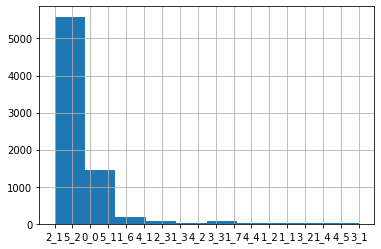

In [29]:
climate_scam_hashtag.roberta_pred.hist()

In [30]:
climate_scam_hashtag[["text", "roberta_pred", "roberta_proba"]]

,text,roberta_pred,roberta_proba
0,@AdvLivingSys @climate_fact @ECOWARRIORSS USA climate is natural just like it is everywhere else on the Earth. #ClimateScam knows Climate Armageddon sophistry piggy-backs on these natural events,2_1,0.973155
2,"Yes, that is part of the longer term climate change. #ClimateScam does not want you to know this, but the Bray and Eddy solar cycles are the primary climate change drivers over the last few thousand years. Milankovitch is even longer term - and not shown here. https://t.co/XXkgdwBVmd https://t.co/LBMzyPDMOO",2_1,0.999557
3,"This Week:\nHooligan party in Rotterdam...\nSpain not that hot, it's a global warming hoax...\n2 months before the death of France...\n#Feyenoord #ClimateScam #Spain #FranceProtests",5_2,0.999287
4,New Climate News: \n\nWho solves super wicked water problems?\n\n#climatecrisis #climateaction #esg #carbon #sustainability #netzero #climatescam #globalwarming #climatechange\nhttps://t.co/FPNCnO4zoo,0_0,0.999764
5,"So Trudeau finally shook off his hangover and tweeted. But instead of tweeting his sympathies and offering support for the people of Alberta, he made these 4 tweets.\n\nDoes this sound like a man who cares about the suffering of Canadians?\n\n#AlbertaWildfires #ClimateScam… https://t.co/nZxcyDeiCe https://t.co/hnykwLcfVX",0_0,0.965996
...,...,...,...
9681,"He's right!! More Conservative wealthy people need to speak out against the Liberal wealthy people who are acting the fool and crazy with all these arrests, mandates &amp; outlandish theories! Who is this guy?? Tell him I said: GOD BLESS YOU. \n\n#ClimateScam https://t.co/8OU2GDzF2B https://t.co/3XnUMCGjPq",5_2,0.997552
9684,"All superstitious nonsense. The #ClimateScam mers, don't know when to quit. 😂😂😂 https://t.co/LLcirGYoIG",5_2,0.999361
9686,@CodeRedEarth @djspratt I think you meant #ClimateScam Yes? It's the CO2 scam that gets you every time.,5_2,0.999490
9687,I think you meant #ClimateScam Yes? It's the CO2 scam that gets you every time. https://t.co/7OIUCf4LJK,5_2,0.999339


In [31]:
climate_scam_hashtag.loc[
    climate_scam_hashtag.roberta_pred=="0_0", ["text", "roberta_pred", "roberta_proba"]].sample(10)

,text,roberta_pred,roberta_proba
5434,"Panama Supreme Court rejects legalization of same-sex ‘marriage,’ says it’s not a ‘human right’ – https://t.co/NWp759uvCV\n\n#NewWorldOrder #WEF #DiedSuddenly #GreatReset #Agenda2030 #nwo #15minutecities #DigitalID #climatescam #SocialCreditSystem #cb...\nhttps://t.co/6iyegNhYUw",0_0,0.999790
1229,@Stephen90045069 @pauladamsalber1 @ejwwest @TheDisproof @aSinister @freddie07068768 @njbtweet @NoelTurner194 @GlennCarr6 @jimdtweet @Kenneth72712993 @starkicus @WayneAllanH @Narvuntien @SumErgoMonstro @shicks_sam @CrispyCX @keithamccluskey @rln_nelson @Michael_D_Crow @priscian @Skrued1 @aaa21usa @MikeDel21893959 @variegated2 @organicdot @Veritatem2021 @NewNormality20 @MedBennett @Jagster20548365 @BubbasRanch @IngersolRobert @ponycar06 @MartinJBern @ChrisBBacon3 @yeg_sewer_rat @Robin_Hagues @mugger124 @Barbarajdurkin @BarbaraGirouard @Marcusgibson @climate_fact @BlasphemousBan1 @RickLazzarini You follow the flute that played those tunes. Same thing! #ClimateScam,0_0,0.997633
3933,"Happy 100th Birthday to Senator, Undersecretary, and Judge James L. Buckley\n\n#NewWorldOrder #WEF #DiedSuddenly #GreatReset #Agenda2030 #nwo #15minutecities #DigitalID #climatescam #SocialCreditSystem #cbdc #PureBlood #chemtrails #billgates #klausschwa...\nhttps://t.co/ThD51lp0XG",0_0,0.999807
5353,@Doranimated @Zigmanfreud #ClimateScam \n\n@RandPaul @SenMikeLee \n@MarshaBlackburn \n@SenLummis @SenTuberville \n@PASenateGOP @PAHouseGOP\n@GovAbbott @GovRonDeSantis\n@Potus @SenTedCruz \n_,0_0,0.998854
6851,"@ThierryAaron So, you ask for what you know to be impossible. Create anxiety, depression and enable globalists to seize control of countries through false narratives. Your narrative is just eco-terrorism for anxious people and little children nightmares. #climatescam",0_0,0.652890
8184,@benmooreau @RohanEarth @Veritatem2021 @4tis @Fossil_Herb @MikeDel21893959 @OscarsWild1 @OzzmanOsgood @Doctordapp @Pickles80936045 @PsiloX @NOfPPlus @MartinBrampton @stephen47276303 @AndreGrossza @weberj502 @JimBowersclimb @bullburton @d_e_mol @ianbrow97534170 @twit4thot @Lurker99821783 @ObliviousReaper @RoyPentland @Royalacresrod @WorkerHere @mike_maric @Robin_Hagues @johnson_wrjohn1 @WernerReinhard5 @Sasha67Oz @automatrix66_KC @Robertchef77 @ClimatePoet @lukasjschreiber @BlasphemousBan1 @The19573159Lad @TLBSociety @FrijnsRik @davidwatt_uk @FriendsOScience @JanChvojka @_LukeCSkywalker @markp1950 @johanhofman @Barrtecforever @molenaarder @ianrowley677 Our emissions trajectory has slackened?\nYou really are naive.\n#ClimateCrisis #ClimateScam #ClimateEmergency https://t.co/QAP2pJIHvj,0_0,0.999761
7536,"If the liberals / libtards could SEE what the Truth is, they would absolutely change their belief in the instant. \n\nI don’t like betting 100% on things, but this one I am 100% confident in it. \n\n#liberals #truth #woke #blm #transillness #WEF #climatescam #suddendeath",0_0,0.999572
759,"@BMZ_Bund @Bundeskanzler @RegSprecher @GermanyinKenya @KenGenKenya @Diplo_Jazz @KfW_FZ @KfW_int @KfW_FZ_int Vielleich sollte Sie, liebe Profis vom @BMZ_Bund und dem @Bundeskanzler erst einmal die Probleme mit der Geothermie im eigenen Land lösen, bevor Sie in die Ferne schweifen:\n#Energiewende\n#Kenia\n#ClimateScam\nhttps://t.co/6VJq18VJrb",0_0,0.999524
3338,#ClimateScam watch this ⬇️⬇️ https://t.co/yEmFNjOKMk,0_0,0.996273
5673,🤣 @JustStop_Oil JUST GOT STOPPED. Selfish fuc#ers - read your own comments most hate what you're doing. Hope all arrested are charged. #ClimateEmergency #climatescam https://t.co/HqjPgUgHWH,0_0,0.997921


In [32]:
results['roberta_preprocessed'] = results["text"].astype(str).apply(denoise_text)
predictions, raw_outputs = roberta_model.predict(list(results.roberta_preprocessed))
results['roberta_pred'] = le.inverse_transform(predictions)
results['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/envs/uni/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:2253: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_pred, counts = mode(pred_row)


In [33]:
results[["text", "roberta_pred", "roberta_proba"]]

,text,roberta_pred,roberta_proba
0,"Greenies believe crisis sells. Per NPR: ""climate change is making aircraft turbulence worse."" No real world turbulence data demonstrating a problem in a warming world was included. The usual ""climate model studies"" for 60 years into the future were referenced. Send $ #climatescam",0_0,0.582158
1,"Mitsubishi &amp; South Pole, both ""carbon credit sellers"", announced one of the largest carbon removal “advanced purchases” to date. Promises to remove climate pollution from the atmosphere are everywhere, but where does the $ go? Net Zero = accounting schemes. You pay! #climatescam",0_0,0.917766
2,"@TonyClimate @MichaelEMann We are blocked as well. Truth be told he's in our book, our historical narrative, he's quoted many times and he's been wrong over and over and over. All from his own predictions. #ClimateScam https://t.co/1ngS6rn5jj",5_2,0.999395
3,"The U.S. nat gas pipeline network is vulnerable to electric outages. Greenies pressured Texas to require electric compressors (not gas powered) on natural gas pipelines. The industry got into big problems when the 2021 freeze collapsed the grid. Just say no, people! #climatescam",4_1,0.420037
4,"CA has been irresponsible not adding reservoirs &amp; capacity. No new reservoirs came online during the past 40 years, as population doubled. More reservoirs would hold more water for slow release &amp; make huge resources available. But they're working on reparations? #climatescam",0_0,0.974588
5,More re: Whales: Research Environmental Impact Statements (EIAs) have buried in 1000's of pages NOAA's acknowledgment of the deadly threat of offshore wind development to marine mammals. It's in documents that are subject to judicial review. So why lie? Follow the $. #climatscam,0_0,0.848763
6,The Natural Resources Council once went to SCOTUS to stop the Navy’s seismic testing. Now dead whales &amp; dolphins wash up on NJ &amp; NY beaches (9 whales since December). Biden wants wind &amp; solar at any cost; NOAA &amp; Greenpeace say whale deaths = right-wing lies. Sad. #climatescam,0_0,0.922922


In [34]:
file = "../Twitter_scrapped/@ClimateScam_CARDS_predictions_{}.csv".format(today)
climate_scam_hashtag.to_csv(file)

### CTTs

In [35]:
tweets['roberta_preprocessed'] = tweets["text"].astype(str).apply(denoise_text)

In [36]:
predictions, raw_outputs = roberta_model.predict(list(tweets.roberta_preprocessed))

  0%|          | 0/7812 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

/opt/conda/envs/uni/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:2253: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_pred, counts = mode(pred_row)


In [37]:
tweets['roberta_pred'] = le.inverse_transform(predictions)
tweets['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

In [38]:
# tweets = pd.read_csv("@Twitter_CTTs_predictions.csv")
tweets.roberta_pred.value_counts().to_frame().head()

,roberta_pred
0_0,7751
5_2,50
4_1,6
5_1,2
2_3,1


In [39]:
tweets[tweets.referenced_tweets.isna()].shape

(743, 18)

<AxesSubplot:>

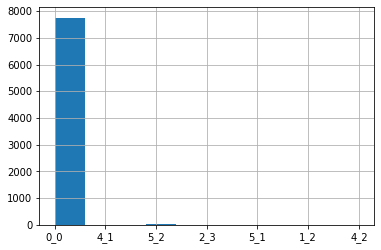

In [40]:
tweets.roberta_pred.hist()

In [41]:
tweets[["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
5841,@Vegasdave59 @Silky422 @NileGardiner @OversightPR @Heritage You don’t speak for no one but you. https://t.co/khm4wFlPFo,0_0,0.999791
1852,"Where Our Students Are Educated: Measuring Student Enrolment in Canada, 2022 https://t.co/27oZMZwMLY via @FraserInstitute",0_0,0.999792
1772,@ccdeditor @CFACT Nearly all freight train engines are currently propelled by electric motors. The diesel engines turn generators that power them. What are they getting at here? Where will they get the electricity from if they eliminate the generators?,0_0,0.747260
1787,@iealondon @FraserInstitute This video doesn’t really cover the idea you mentioned. I think this is the one.\nhttps://t.co/gmvv1WlRku,0_0,0.999743
2565,@SpeakerMcCarthy @Heritage Even your orange god knew that the debt ceiling should not become a playing piece in a negotiation.,0_0,0.999759


In [42]:
tweets.loc[tweets.roberta_pred!="0_0", ["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
6624,"@kasbti @Bishop_Of_Souls @NileGardiner @OversightPR @Heritage He's part of a vast Hydra of Right Wing shills that clog up Twitter trying to push Brits further Right, and distracting them whilst the Conservatives rob the country blind.",5_2,0.721642
6094,"@NileGardiner @OversightPR @Heritage What a ridiculous PR stunt, let me guess trying to distract from the coronation that no one cares about??",5_2,0.989422
5594,"@aroberts_andrew 2 historians - 1 was given a peerage by Johnson for writing BS about Johnson's downfall &amp; visiting Koch funded think tanks, @Heritage &amp; the vile @NileGardiner \nThe other historian - honest and exactly correct:\nhttps://t.co/UJWS00cHYY\n@aroberts_andrew should be kicked out of HoL. https://t.co/Tznouu7NRR",5_2,0.680173
3500,"@lazlototh67 @BenGoldey @Heritage Not stupid at all. Indirect funding of so-called research orgs, govt regulatory agencies, and so-called independent news media is the crux of the problem, where orgs that we trust are basically acting as propaganda / marketing depts for their respective funders.",5_2,0.997194
4185,@Heritage Who is funding the Heritage Foundation‘s so-called investigation into Prince Harry’s US immigration documents? The fanatical British right-wing media or a white supremicist organization?,5_2,0.990794


In [43]:
file_CTT = "../Twitter_scrapped/@Twitter_CTTs_predictions_{}.csv".format(today)
tweets.to_csv(file_CTT)

In [44]:
# samples = (
#     tweets.groupby("roberta_pred")
#     .sample(10, replace=True)[["text", "roberta_pred", "roberta_proba"]]
#     .drop_duplicates("text")
# )
# samples.to_csv("@Twitter_CTTs_predictions_samples.csv")

### Denials

In [45]:
tweets_denials['roberta_preprocessed'] = tweets_denials["text"].astype(str).apply(denoise_text)
predictions, raw_outputs = roberta_model.predict(list(tweets_denials.roberta_preprocessed))

  0%|          | 0/7812 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

/opt/conda/envs/uni/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:2253: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_pred, counts = mode(pred_row)


In [46]:
tweets_denials['roberta_pred'] = le.inverse_transform(predictions)
tweets_denials['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

In [47]:
# tweets_denials = pd.read_csv("@Twitter_Denials_predictions.csv")

In [48]:
tweets_denials.roberta_pred.value_counts().to_frame().head()

,roberta_pred
0_0,7751
5_2,50
4_1,6
5_1,2
2_3,1


<AxesSubplot:>

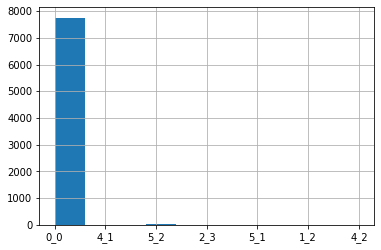

In [49]:
tweets_denials.roberta_pred.hist()

In [50]:
tweets_denials[["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
4712,@SenatorSinema When @Heritage bought you they shopped big.,0_0,0.999731
7192,"@StaggerLee2112 @deadendangel @markary77 @WalshFreedom @Heritage @FoxNews I know I have fewer than 100 followers, but let's be real: a blue check is more than just a status symbol. Selling verification undermines its authenticity and value. Twitter can sell exclusive features without tying them to verification status.",0_0,0.999758
4311,"@BenGoldey @Heritage She is incredibly good at responding to Senator Whitehouse question and reminding him who he is, a corrupt two faced muck raker!",0_0,0.999381
4202,@BenGoldey @Heritage She is just amazing.,0_0,0.999782
2499,@KevinRobertsTX @BasedMikeLee @Heritage @SpeakerMcCarthy Let’s talk DHS-Let’s talk elections. It’s not just about censorship. @Jim_Jordan The TX Dir of Elec testified before congress. He lied. This is how DHS got into our elections. If the DHS does such a great job-how did Konnech use China servers. We have the receipts. https://t.co/racAK5TLrW,0_0,0.999663


In [51]:
tweets_denials.loc[tweets_denials.roberta_pred!="0_0", ["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
6822,"@Heritage That knucklehead illegally entered this country TWICE during the #Trump administration and Trumps billion dollar WALL accomplished, what??? https://t.co/bCUVbAP6oQ",5_2,0.861272
468,@ericuman @AEI So Eric are you also upset at Joe Biden staying at billionaire donors houses multiple times while serving as VP and as President?? Or does he get a fucking pass because he is a fucking liberal???,5_2,0.835268
4185,@Heritage Who is funding the Heritage Foundation‘s so-called investigation into Prince Harry’s US immigration documents? The fanatical British right-wing media or a white supremicist organization?,5_2,0.990794
4231,@DFR_Economics @Heritage The EV our government is forcing on the US Postal Service will be a disaster. Even in an Iowa winter they will have difficulty staying charged. Snow and ice covered rural roads are not an EV’s friend.,4_1,0.965653
6704,@NileGardiner @OversightPR @Heritage All fake Nile\nThese papers have been sorted long ago\nNice try\nHow is the con a nation coming along https://t.co/Rs2ThNO2tz,5_2,0.731270


In [52]:
file_denials = "../Twitter_scrapped/@Twitter_Denials_predictions_{}.csv".format(today)
tweets_denials.to_csv(file_denials)

In [53]:
samples = (
    tweets_denials.groupby("roberta_pred")
    .sample(10, replace=True)[["text", "roberta_pred", "roberta_proba"]]
    .drop_duplicates("text")
)
samples.to_csv("@Twitter_Denials_predictions_samples.csv")